Reset 后的初始位置（保留两位小数）：[0.55, 0.4, -0.05, -0.1, -0.7]


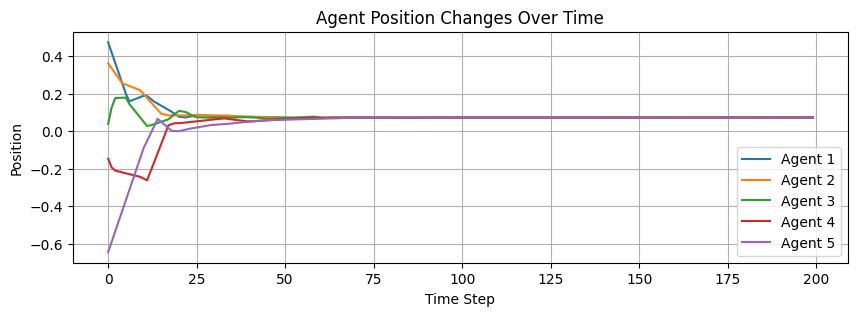

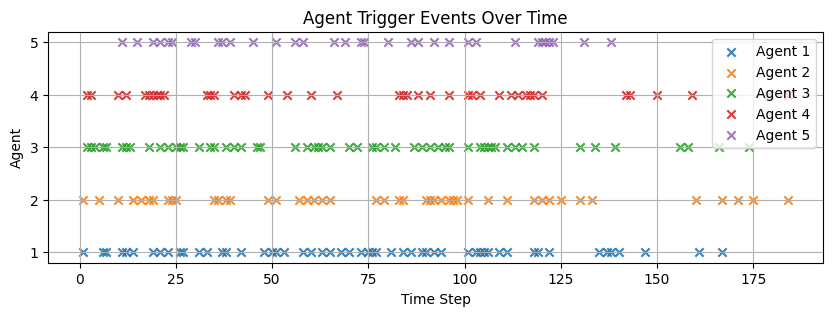

Actions History:
[0, 0, 0, 0, 0]
[1, 1, 0, 0, 0]
[0, 0, 1, 1, 0]
[0, 0, 1, 1, 0]
[0, 0, 1, 0, 0]
[0, 1, 0, 0, 0]
[1, 0, 1, 0, 0]
[1, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 1, 0]
[1, 0, 1, 0, 1]
[1, 0, 1, 1, 0]
[0, 0, 1, 0, 0]
[1, 1, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 1, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 1, 1, 1, 0]
[1, 1, 0, 1, 1]
[0, 0, 0, 1, 0]
[1, 0, 1, 1, 1]
[0, 0, 0, 1, 0]
[1, 1, 1, 0, 1]
[0, 1, 0, 0, 1]
[0, 1, 1, 0, 0]
[1, 0, 1, 0, 0]
[1, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 1]
[1, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 0, 1, 0]
[0, 0, 1, 1, 0]
[0, 1, 1, 1, 0]
[0, 1, 0, 0, 1]
[1, 0, 0, 0, 1]
[1, 1, 1, 0, 0]
[0, 1, 0, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 0, 0, 0]
[1, 0, 1, 1, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 0, 1, 0]
[1, 0, 0, 0, 0]
[1, 1, 0, 0, 1]
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 1, 0, 1]
[0, 1, 0, 0, 0]
[1, 0, 0, 0, 1]
[0, 1, 1, 0, 0]
[1, 0, 0, 1, 0]
[0, 1, 

In [119]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from env_new.MAenv_3 import CustomMAEnvironment3

# 定义 PolicyNetwork
class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

# 加载策略函数
def load_policies(env, policies_path):
    agents = env.agents
    policies = {}
    for agent in agents:
        policy = PolicyNetwork(
            env.observation_space(agent).shape[0],
            env.action_space(agent).n
        )
        policy.load_state_dict(torch.load(f"{policies_path}/{agent}_policy.pth"))
        policy.eval()  # 设置为评估模式
        policies[agent] = policy
    return policies

# 模拟代码
def simulate_env(env, policies, num_steps=200, modification_prob_min=0.5, modification_prob_max=0.8, no_mod_steps=125):
    obs = env.reset()
    print(f"Reset 后的初始位置（保留两位小数）：{env.initial_positions}")
    agents = env.agents
    
    actions_history = []
    positions_history = np.zeros((num_steps, len(agents)))
    
    for t in range(num_steps):
        actions = {}
        
        # 如果当前时间步大于 no_mod_steps，则逐渐增加修改动作的概率
        if t >= no_mod_steps:
            # 随着时间步 t 增加，从 no_mod_steps 步的修改概率为 modification_prob_min，线性增加到 modification_prob_max
            modification_prob = np.clip(modification_prob_min + (modification_prob_max - modification_prob_min) * (t - no_mod_steps) / (num_steps - no_mod_steps), modification_prob_min, modification_prob_max)
        else:
            modification_prob = 0  # 前 no_mod_steps 步不修改动作
        
        for agent in agents:
            obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
            with torch.no_grad():
                logits = policies[agent](obs_tensor)
            probs = torch.softmax(logits, dim=-1)
            action = torch.multinomial(probs, 1).item()
            
            # 根据修改概率决定是否修改动作
            if np.random.rand() < modification_prob:
                action = 0  # 将动作修改为 0 (表示所有智能体的动作为 0)
            
            actions[agent] = action

        # 保存当前时间步的动作选择
        actions_history.append([actions[agent] for agent in agents])
        
        # 环境交互
        obs, _, _, _ = env.step(actions)
        
        # 保存当前时间步的智能体位置
        for i, agent in enumerate(agents):
            positions_history[t, i] = env.agent_objs[i].position
    
    return actions_history, positions_history




# 可视化函数
def plot_results(actions_history, positions_history, env):
    # 绘制智能体位置变化
    plt.figure(figsize=(10, 3))
    for i, agent in enumerate(env.agents):
        plt.plot(positions_history[:, i], label=f"Agent {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Position")
    plt.title("Agent Position Changes Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制触发情况
    plt.figure(figsize=(10, 3))
    for i, agent in enumerate(env.agents):
        triggers = [t for t, action in enumerate(actions_history) if action[i] == 1]
        plt.scatter(triggers, [i+1] * len(triggers), label=f"Agent {i+1}", alpha=0.9, marker='x')  # 修改为 'x'
    plt.xlabel("Time Step")
    plt.ylabel("Agent")
    plt.title("Agent Trigger Events Over Time")
    plt.yticks(range(1, len(env.agents)+1))
    plt.grid()
    plt.legend()
    plt.show()

# 主函数
if __name__ == "__main__":
    # 创建环境
    env = CustomMAEnvironment3(num_agents=5, num_iterations=200, dt=0.1)

    # 加载策略
    policies = load_policies(env, policies_path=".")

    # 模拟环境交互
    actions_history, positions_history = simulate_env(env, policies, num_steps=200)

    # 绘制结果
    plot_results(actions_history, positions_history, env)

    # 输出所有动作选择矩阵
    print("Actions History:")
    for actions in actions_history:
        print(actions)
    
    

Reset 后的初始位置（保留两位小数）：[0.55, 0.4, -0.05, -0.1, -0.7]


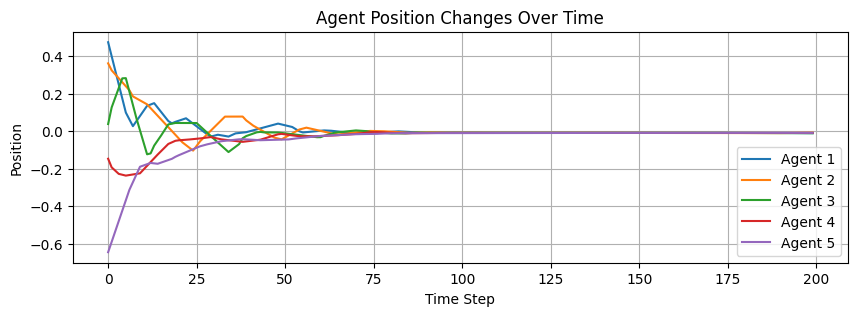

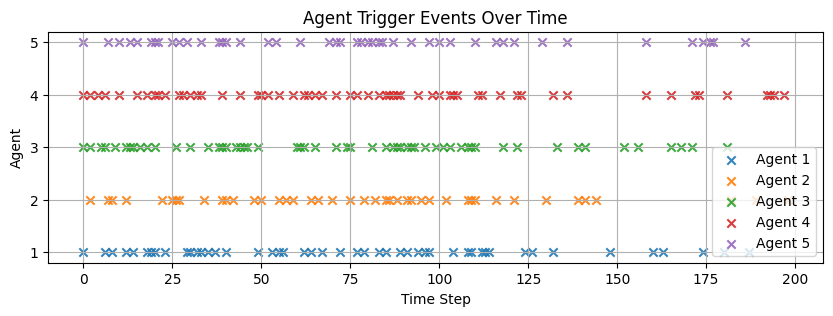

Actions History:
[1, 0, 1, 1, 1]
[0, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 0, 1, 0, 0]
[1, 0, 1, 1, 0]
[0, 1, 0, 0, 1]
[1, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 1, 1]
[0, 0, 0, 0, 0]
[1, 1, 1, 0, 0]
[0, 0, 1, 0, 1]
[1, 0, 1, 0, 0]
[0, 0, 0, 1, 1]
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 1, 1, 0]
[1, 0, 0, 0, 1]
[1, 0, 1, 1, 1]
[0, 0, 0, 1, 1]
[0, 1, 0, 0, 0]
[1, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 1]
[0, 1, 1, 0, 0]
[0, 1, 0, 1, 1]
[0, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[1, 0, 1, 1, 0]
[0, 0, 0, 0, 0]
[1, 0, 0, 1, 0]
[1, 0, 0, 1, 1]
[0, 1, 0, 0, 0]
[1, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 1, 0, 1]
[0, 1, 1, 1, 1]
[1, 1, 1, 0, 1]
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 1, 1]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[1, 0, 1, 1, 0]
[0, 1, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 1, 1]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[1, 1, 0, 1, 0]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 1, 0]
[0, 0, 1, 0, 0]
[0, 0, 

In [154]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from env_new.MAenv_shared import CustomMAEnvironment

# 定义 PolicyNetwork
class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

def load_shared_policy(env, policy_path="shared_policy.pth"):
    """
    加载一个共享的策略网络。假设所有Agent的观测维度和动作维度相同。
    """
    # 以第一个智能体的观测动作空间作为参考
    first_agent = env.agents[0]
    obs_dim = env.observation_space(first_agent).shape[0]
    act_dim = env.action_space(first_agent).n

    # 创建并加载权重
    policy = PolicyNetwork(obs_dim, act_dim)
    policy.load_state_dict(torch.load(policy_path))
    policy.eval()  # 设置为评估模式
    return policy

def simulate_env(env, shared_policy, num_steps=200, modification_prob_min=0.5, modification_prob_max=0.8, no_mod_steps=125):
    """
    模拟环境交互，包含修改动作的逻辑。
    modification_prob_min: 第 125 步时的最小修改概率
    modification_prob_max: 第 200 步时的最大修改概率
    no_mod_steps: 前多少步不修改动作
    """
    obs = env.reset()
    print(f"Reset 后的初始位置（保留两位小数）：{env.initial_positions}")
    agents = env.agents
    
    actions_history = []
    positions_history = np.zeros((num_steps, len(agents)))
    
    for t in range(num_steps):
        actions = {}
        
        # 如果当前时间步大于 no_mod_steps，则逐渐增加修改动作的概率
        if t >= no_mod_steps:
            # 随着时间步 t 增加，从 no_mod_steps 步的修改概率为 modification_prob_min，线性增加到 modification_prob_max
            modification_prob = np.clip(modification_prob_min + (modification_prob_max - modification_prob_min) * (t - no_mod_steps) / (num_steps - no_mod_steps), modification_prob_min, modification_prob_max)
        else:
            modification_prob = 0  # 前 no_mod_steps 步不修改动作
        
        for i, agent in enumerate(agents):
            # 同一个网络，根据各自的obs选取动作
            obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
            with torch.no_grad():
                logits = shared_policy(obs_tensor)
            probs = torch.softmax(logits, dim=-1)
            action = torch.multinomial(probs, 1).item()
            
            # 根据修改概率决定是否修改动作为 [0, 0, 0, 0, 0]
            if np.random.rand() < modification_prob:
                action = 0  # 将动作修改为 0 (表示所有智能体的动作为 0)
            
            actions[agent] = action

        actions_history.append([actions[agent] for agent in agents])
        
        # 环境交互
        obs, _, _, _ = env.step(actions)
        
        # 保存当前时间步的智能体位置
        for i, agent in enumerate(agents):
            positions_history[t, i] = env.agent_objs[i].position
    
    return actions_history, positions_history

def plot_results(actions_history, positions_history, env):
    # 绘制智能体位置变化
    plt.figure(figsize=(10, 3))
    for i, agent in enumerate(env.agents):
        plt.plot(positions_history[:, i], label=f"Agent {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Position")
    plt.title("Agent Position Changes Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制触发情况
    plt.figure(figsize=(10, 3))
    for i, agent in enumerate(env.agents):
        triggers = [t for t, action in enumerate(actions_history) if action[i] == 1]
        plt.scatter(triggers, [i+1] * len(triggers), label=f"Agent {i+1}", alpha=0.9, marker='x')
    plt.xlabel("Time Step")
    plt.ylabel("Agent")
    plt.title("Agent Trigger Events Over Time")
    plt.yticks(range(1, len(env.agents)+1))
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # 创建环境
    env = CustomMAEnvironment(num_agents=5, num_iterations=200, dt=0.1)
    
    # 加载共享策略网络
    shared_policy = load_shared_policy(env, policy_path="shared_policy.pth")
    
    # 模拟环境交互
    actions_history, positions_history = simulate_env(env, shared_policy, num_steps=200)

    # 绘制结果
    plot_results(actions_history, positions_history, env)
    
    # 输出所有动作选择矩阵
    print("Actions History:")
    for actions in actions_history:
        print(actions)
